# Overview

The hustle and bustle of the city isn't always so seamless. Between 2012 and 2025, over 2,000,000 car accidents and 379,000 injurues occurred across the busy streets of New York City. Maybe were taking bumper to bumper traffic a little too seriously. The goal of this analysis will be to determine where and why these accidents occurred as well as break down influencing factors that led to them. The last 5 complete years of data (2019-2024) were used to assess yearly trends and see where the big apple is headed.

# Datasets

The initial accidents dataset was sourced from NYC Open Data and contained 2,167,918 rows of incidents and 29 columns with the associated information that was recorded. However, for the purposes of this analysis, only 18 rows were imported. Columns were broken down into the following:

* The **CRASH DATE** column contains the date of each accident in mm/dd/yyyy format (e.g., 09/11/2021)
* The **CRASH TIME** column contains the hour and minute each accident occurred represented in military time(e.g.,13:21)
* The **BOROUGH** column contains the name of the NYC borough the accident occurred in (e.g., MANHATTAN, BROOKLYN, QUEENS)
* The **NUMBER OF PERSONS INJURED** column contains the number of people injured in each accident e.g., 4)
* The **NUMBER OF PERSONS KILLED** column contains the number of people killed in each accident e.g., 4)
* The **NUMBER OF PEDESTRIANS INJURED** column contains the number of pedestrians injured in each accident (e.g., 3)
* The **NUMBER OF PEDESTRIANS KILLED** column contains the number of pedestrians killed in each accident (e.g., 0)
* The **NUMBER OF CYCLISTS INJURED** column contains the number of pedestrians injured in each accident (e.g., 2)
* The **NUMBER OF CYCLISTS KILLED** column contains the number of pedestrians killed in each accident (e.g., 1)
* The **NUMBER OF MOTORISTS INJURED** column contains the number of motorists injured in each accident (e.g., 2)
* The **NUMBER OF MOTORISTS KILLED** column contains the number of motorists killed in each accident (e.g., 1)
* The **CONTRIBUTING FACTOR VEHICLE 1** columns contains the recorded the reason the primary vehicle got in an accident (e.g.,. Driver Inexperience)
* The **CONTRIBUTING FACTOR VEHICLE 2** columns contains the recorded the reason the secondary vehicle got in an accident (Following Too Closely).
* The **COLLISION_ID** column contains the unique identifier for each accident (e.g., 4455765).
* The **VEHICLE TYPE CODE 1** column contains the type of the primary vehicle(e.g., Sedan).
* The **VEHICLE TYPE CODE 2** column contains the type of the secondary vehicle(e.g., Box Truck).
* The **LATITUDE** column contains the latitude value of each accident.
* The **LONGITUDE** column contains the longitude value of each accident.

The Initial traffic volume dataset was also sourced from NYC Open Data and contained over 1,700,000 samples of traffic through various checkpoints like bridges and tunnels all over NYC at various times of the year. Counts were not all encompassing For the purposes of this analysis only 2 out of 14 columns were imported. Columns were broken down into the following:

* The **Yr** column contains the year of each sample (e.g., 2021)
* The **Vol** column contains the number of cars that passed the checkpoint over a 15 minute period. (e.g., 1150)

# Necessary Libraries

In [1]:
!pip install python-Levenshtein #Installing Levenshtein
!pip install swifter # Installing swifter

import swifter #Importing swifter to improve the performance of .apply()
import Levenshtein #Importing Levenshtein to improve performance of fuzzywuzzy
import pandas as pd #importing pandas
from fuzzywuzzy import fuzz # Importing fuzz to consolidate mispelled words
import matplotlib.pyplot as plt # Importing Seaborn to create visualizations
import seaborn as sns # Importing pyplot to create visualizations
import geopandas as gpd # Importing geopandas to work with geospatial data
from shapely.geometry import Point # importing Point to create geometric point objects


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/153.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=c1e180fa2d8c43323b1fc48f023eac08bc771a576049efe006e57aa7a8d1e532
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [2]:
pd.options.display.float_format = '{:,.0f}'.format
pd.options.display.max_columns = None

# Inspecting the dataframe

After its creation, the dataframe's info and number of null values were taken to gain more insight. The borough, contributing_factor_vehicle_2, vehicle_type_code_2, latitude, and longitude columns contained a large number of null values. This may be due to inconsistencies or mistakes in police reports. The vehicle_type_code_1 and contributing_factor_vehicle_1 also contained null values to a lesser extent. Accident data for all of 2025 was not available, as the year is incomplete. 

In [3]:
# Creating dataframe with relevant columns
traffic_df = pd.read_csv('/kaggle/input/nyc-open-data-accidents/Motor_Vehicle_Collisions_-_Crashes_20250815.csv',usecols = ['NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','CRASH DATE','CRASH TIME','BOROUGH','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','COLLISION_ID','VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','LATITUDE','LONGITUDE'])

# Creating list of updated col names
new_columns = ['crash_date','crash_time', 'borough','latitude','longitude',
'number_of_persons_injured','number_of_persons_killed','number_of_pedestrians_injured',
'number_of_pedestrians_killed','number_of_cyclist_injured','number_of_cyclist_killed',
'number_of_motorist_injured','number_of_motorist_killed','contributing_factor_vehicle_1',
'contributing_factor_vehicle_2','collision_id','vehicle_type_code_1','vehicle_type_code_2']

# Assigning column names
traffic_df.columns = new_columns 

In [4]:
traffic_df.isnull().sum()

crash_date                            0
crash_time                            0
borough                          457928
latitude                          92682
longitude                         92682
number_of_persons_injured            17
number_of_persons_killed             30
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
contributing_factor_vehicle_1      5664
contributing_factor_vehicle_2    244296
collision_id                          0
vehicle_type_code_1               13288
vehicle_type_code_2              342702
dtype: int64

In [5]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328495 entries, 0 to 1328494
Data columns (total 18 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   crash_date                     1328495 non-null  object 
 1   crash_time                     1328495 non-null  object 
 2   borough                        870567 non-null   object 
 3   latitude                       1235813 non-null  float64
 4   longitude                      1235813 non-null  float64
 5   number_of_persons_injured      1328478 non-null  float64
 6   number_of_persons_killed       1328465 non-null  float64
 7   number_of_pedestrians_injured  1328495 non-null  int64  
 8   number_of_pedestrians_killed   1328495 non-null  int64  
 9   number_of_cyclist_injured      1328495 non-null  int64  
 10  number_of_cyclist_killed       1328495 non-null  int64  
 11  number_of_motorist_injured     1328495 non-null  int64  
 12  number_of_moto

# Cleaning the dataframe

9 out of the 18 columns contained null values. Outside of the borough, contributing_factors_vehicle_2, and vehicle_type_code_2 columns, these null values were negligible and represented less than 10 percent of the data frame. Null values outside of the borough column were left as imputation methods would not affect the calculated statistics.

The Shapely and GeoPandas libraries were used to create a function mapping longitude and latitude pairs to their respective boroughs using a geographic dataframe. This reduced the number of null values in the borough column by 82%. This approach was faster and more accurate than methods using APIs or general borough boundaries. To clean the vehicle type columns a list of correct common vehicle spellings were passed into a separate function to standardize incorrect spellings using the fuzzywuzzy library.


The crash_date and crash_time columns were converted into datetime format to allow for time comparisons and calculations to be run. The number_of_persons_injured and number_of_persons_killed columns were also converted from the object to the float64 data type. The dataframe was then filtered to include the last five complete years of data (2018-2024). This allowed for faster processing and a focus on recent trends. 

In [6]:
# Converting data types and filtering years
traffic_df['crash_date'] = pd.to_datetime(traffic_df['crash_date'])
traffic_df['crash_time'] = pd.to_datetime(traffic_df['crash_time'], format='%H:%M', errors='coerce')
traffic_df['number_of_persons_injured'] = pd.to_numeric(traffic_df['number_of_persons_injured'])
traffic_df['number_of_persons_killed'] = pd.to_numeric(traffic_df['number_of_persons_killed'])

traffic_df = traffic_df[(traffic_df['crash_date'].dt.year >= 2018) & (traffic_df['crash_date'].dt.year < 2025)]

In [7]:
# Calculating % of null values
null_rows = traffic_df.isnull().sum()
total_rows = len(traffic_df)
print((null_rows/total_rows * 100).round(2))

crash_date                       0
crash_time                       0
borough                         34
latitude                         8
longitude                        8
number_of_persons_injured        0
number_of_persons_killed         0
number_of_pedestrians_injured    0
number_of_pedestrians_killed     0
number_of_cyclist_injured        0
number_of_cyclist_killed         0
number_of_motorist_injured       0
number_of_motorist_killed        0
contributing_factor_vehicle_1    0
contributing_factor_vehicle_2   19
collision_id                     0
vehicle_type_code_1              1
vehicle_type_code_2             27
dtype: float64


### Cleaning The "borough" Column

In [8]:
# Loading NYC borough boundaries from NYC Open Data

url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary_Water_Included/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
boundaries_gdf = gpd.read_file(url)
    
print(f"Successfully loaded {len(boundaries_gdf)} borough boundaries")
print("Borough names:", boundaries_gdf['BoroName'].tolist())

def get_borough_from_coordinates_geopandas(traffic_df, boundaries_gdf):
    """Vectorized borough determination using GeoPandas for large datasets"""
    # Filtering for rows with missing boroughs and valid coordinates
    missing_borough_mask = traffic_df['borough'].isna()
    valid_coords_mask = traffic_df['latitude'].notna() & traffic_df['longitude'].notna()
    process_mask = missing_borough_mask & valid_coords_mask


    # Creating GeoDataFrame from traffic data coordinates, preserving original index
    subset_df = traffic_df.loc[process_mask].copy()
    geometry = [Point(lon, lat) for lon, lat in 
                zip(subset_df['longitude'], subset_df['latitude'])]

    points_gdf = gpd.GeoDataFrame(subset_df, geometry=geometry, crs='EPSG:4326')

    # Ensuring both GeoDataFrames use the same CRS
    if boundaries_gdf.crs != points_gdf.crs:
        boundaries_gdf = boundaries_gdf.to_crs(points_gdf.crs)

    # Performing spatial join on points_gdf
    joined = gpd.sjoin(points_gdf, boundaries_gdf, how='left', predicate='within')

    # Updating rows where borough match was found
    borough_found_mask = joined['BoroName'].notna()
    if borough_found_mask.any():
        # Using the index from joined to update the correct rows in the original dataframe
        indices_to_update = joined.index[borough_found_mask]
        borough_values = joined.loc[borough_found_mask, 'BoroName'].str.upper()
        traffic_df.loc[indices_to_update, 'borough'] = borough_values

# Processing coordinates using GeoPandas
if boundaries_gdf is not None: 
    print(f"Missing boroughs before: {traffic_df['borough'].isna().sum()}")
    
    get_borough_from_coordinates_geopandas(traffic_df, boundaries_gdf)
    
    print(f"Missing boroughs after: {traffic_df['borough'].isna().sum()}")

Successfully loaded 5 borough boundaries
Borough names: ['Staten Island', 'Bronx', 'Queens', 'Manhattan', 'Brooklyn']
Missing boroughs before: 326415
Missing boroughs after: 58012


In [9]:
# Analyzing why boroughs are still missing
missing_borough_mask = traffic_df['borough'].isna()
missing_records = traffic_df[missing_borough_mask]
    
print(f"Total records with missing boroughs: {len(missing_records)}")
    
# Checking for missing coordinates
missing_lat = missing_records['latitude'].isna().sum()
missing_lon = missing_records['longitude'].isna().sum()
missing_both = missing_records[missing_records['latitude'].isna() | missing_records['longitude'].isna()]
    
print(f"Records with missing coordinates (either lat or lon): {len(missing_both)}")

print('Remaining records must contain coordinates outside NYC boundaries')

Total records with missing boroughs: 58012
Records with missing coordinates (either lat or lon): 56888
Remaining records must contain coordinates outside NYC boundaries


### Cleaning "vehicle_type_code_1" and  "vehicle_type_code_2" columns

In [10]:
# Checking for unique entries
print(traffic_df['vehicle_type_code_1'].value_counts())
print(traffic_df['vehicle_type_code_2'].value_counts())

vehicle_type_code_1
Sedan                                  440355
Station Wagon/Sport Utility Vehicle    343077
Taxi                                    35882
Pick-up Truck                           24883
Box Truck                               17642
                                        ...  
Detached t                                  1
Ford EC2                                    1
charter bu                                  1
FDNY EMS#1                                  1
KW                                          1
Name: count, Length: 1441, dtype: int64
vehicle_type_code_2
Sedan                                  294727
Station Wagon/Sport Utility Vehicle    234177
Bike                                    26515
Taxi                                    23572
Pick-up Truck                           21881
                                        ...  
VENDOR FOO                                  1
FREIGHT VA                                  1
Gas bicycl                                  1


In [11]:
# Creating list of correct spellings and groupings to check against 'vehicle_type_code_1' column
corrected_vehicles = ['Sedan', 'Pick-up Truck','Bike','Ambulance','Motorcycle','Box Truck','FDNY TRUCK','FDNY Ambulance','Ambulance','Fire Truck','Fire Engine','Passenger','Forklift','Flat Bed','School Bus','Sprinter','U-Haul','USPS','Utility','EMS','E-scooter','Station Wagon/Sport Utility Vehicle', 'PASSENGER VEHICLE', 'SPORT UTILITY / STATION WAGON ','Taxi','Bus','Van']

traffic_df['vehicle_type_code_1'] = traffic_df['vehicle_type_code_1'].astype(str)
traffic_df['vehicle_type_code_2'] = traffic_df['vehicle_type_code_2'].astype(str)


def correct_spelling_optimized(text, correct_list, threshold=50):
    """Optimized spelling correction function"""
    if pd.isna(text) or text == 'nan':
        return text

    # Passing over correct spellings
    if text in correct_list:
        return text

    # Check for any match above threshold
    for correct_word in correct_list:
        if fuzz.ratio(text, correct_word) >= threshold:
            return correct_word

    # Return original if no match found
    return text

# Applying corrections
traffic_df['vehicle_type_code_1'] = traffic_df['vehicle_type_code_1'].swifter.apply(lambda x: correct_spelling_optimized(x, corrected_vehicles))
traffic_df['vehicle_type_code_2'] = traffic_df['vehicle_type_code_2'].swifter.apply(lambda x: correct_spelling_optimized(x, corrected_vehicles))

print(traffic_df['vehicle_type_code_1'].value_counts())
print(traffic_df['vehicle_type_code_2'].value_counts())

Pandas Apply:   0%|          | 0/958319 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/958319 [00:00<?, ?it/s]

vehicle_type_code_1
Sedan                                  441152
Station Wagon/Sport Utility Vehicle    343077
Taxi                                    35911
Pick-up Truck                           25092
Box Truck                               19167
                                        ...  
U-HAUL TRU                                  1
Dept Tow t                                  1
nyc                                         1
Dot                                         1
KW                                          1
Name: count, Length: 1038, dtype: int64
vehicle_type_code_2
Sedan                                  295386
nan                                    261185
Station Wagon/Sport Utility Vehicle    234177
Bike                                    33593
Taxi                                    23605
                                        ...  
Mopad                                       1
CON ED BOX                                  1
dsny sweep                                  1


In [12]:
traffic_df.head().T

,0,1,2,3,4
crash_date,2021-09-11 00:00:00,2022-03-26 00:00:00,2023-11-01 00:00:00,2022-06-29 00:00:00,2022-09-21 00:00:00
crash_time,1900-01-01 02:39:00,1900-01-01 11:45:00,1900-01-01 01:29:00,1900-01-01 06:55:00,1900-01-01 13:21:00
borough,NaN,NaN,BROOKLYN,NaN,NaN
latitude,NaN,NaN,41,NaN,NaN
longitude,NaN,NaN,-74,NaN,NaN
number_of_persons_injured,2,1,1,0,0
number_of_persons_killed,0,0,0,0,0
number_of_pedestrians_injured,0,0,0,0,0
number_of_pedestrians_killed,0,0,0,0,0
number_of_cyclist_injured,0,0,0,0,0


# Exploratory Analysis
###  Traffic volume and Crash Trend
Between 2018 and 2024 a steep decline of traffic accidents can be seen, dropping from 231,564 in 2018 to 91,287 in 2024. A sharp decline can be seen between 2019 and 2020, likely due to the start of the COVID-19 pandemic, which resulted in less travel as more people stayed indoors. Rough traffic volume numbers frm NYC Open Data confirm this. However, accidents continued to decline post pandemic into 2023 which can be attributed to the continued efforts of safetly programs. While injuries generally followed accident trends, fatalities did not. During the peak of the pandemic (2020-2021), the number of fatalities reported was markedly higher than the years before or after. This could be due to increased speeding and reckless driving.

 crash_year accidents number_of_persons_injured number_of_persons_killed
       2018   231,564                    61,940                      231
       2019   211,486                    61,390                      244
       2020   112,917                    44,614                      269
       2021   110,557                    51,784                      297
       2022   103,886                    51,932                      290
       2023    96,606                    54,250                      280
       2024    91,303                    54,023                      266


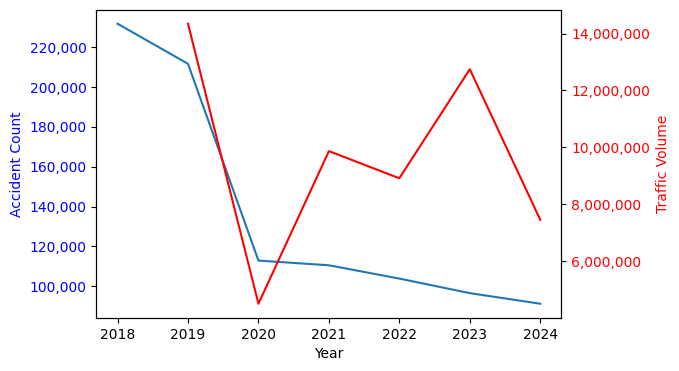

<Figure size 640x480 with 0 Axes>

In [13]:
# Creating dataframe of yearly statistics
traffic_df['crash_year'] = traffic_df['crash_date'].dt.year
traffic_df['accidents'] = traffic_df['collision_id'].count()

# Creating dataframes of collisions,fatalities, and injuries.
accidents = traffic_df.groupby('crash_year')['collision_id'].count().reset_index(name = 'accidents')
fatalities = traffic_df.groupby('crash_year')['number_of_persons_killed'].sum().astype('int')
injuries = traffic_df.groupby('crash_year')['number_of_persons_injured'].sum().astype('int')

# Merging dataframes and outputting results
yearly_breakdown = accidents.merge(fatalities, on='crash_year').merge(injuries, on='crash_year')
yearly_breakdown = yearly_breakdown[['crash_year', 'accidents', 'number_of_persons_injured', 'number_of_persons_killed']]


print(yearly_breakdown.to_string(index = False,
    formatters={c: '{:,}'.format for c in yearly_breakdown.select_dtypes('number') if c != 'crash_year'}
))




# Creating dataframe of sample traffic volume from NYC Open Data
traffic_volume = pd.read_csv('/kaggle/input/nyc-open-data-traffic-counts/Automated_Traffic_Volume_Counts_20250814-2.csv')
yearly_traffic_volume = traffic_volume.groupby('Yr')['Vol'].sum().reset_index(name = 'count')


# Creating lineplot of accidents over the years

# YOU NEED TO FIND A PROPER PLACE FOR THIS
from matplotlib.ticker import FuncFormatter
comma_fmt = FuncFormatter(lambda x, _: f'{int(x):,}')

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot('crash_year','accidents', data = yearly_breakdown)
ax1.set_xlabel('Year')
ax1.set_ylabel('Accident Count',color = 'blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.ticklabel_format(style='plain', axis='both')
ax1.yaxis.set_major_formatter(comma_fmt) 

ax2 = ax1.twinx()  # second y-axis
ax2.plot('Yr','count', color = 'red', data = yearly_traffic_volume)
ax2.set_ylabel('Traffic Volume', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.ticklabel_format(style = 'plain', axis = 'y')
ax2.yaxis.set_major_formatter(comma_fmt)
plt.show()
plt.tight_layout()

In [14]:
yearly_traffic_volume.head()


,Yr,count
0,2019,14348443
1,2020,4497946
2,2021,9866848
3,2022,8911947
4,2023,12747193


In [15]:
#Creating objects for the numebr of accidents,injuries, and fatalities
number_of_accidents = traffic_df['collision_id'].count()
number_of_injuries = traffic_df['number_of_persons_injured'].sum()
number_of_fatalities = traffic_df['number_of_persons_killed'].sum()

print(f"Number of Accidents: {number_of_accidents}")
print(f"Number of Persons Injured: {int(number_of_injuries)}")
print(f"Number of Persons Killed: {int(number_of_fatalities)}")
print(f"Injury Rate: {(number_of_injuries / number_of_accidents)*100:.2f}%")
print(f"Fatality Rate: {(number_of_fatalities / number_of_accidents)*100:.2f}%")

Number of Accidents: 958319
Number of Persons Injured: 379933
Number of Persons Killed: 1877
Injury Rate: 39.65%
Fatality Rate: 0.20%


### Hourly Accident Breakdown
Accidents occur the most between the hours of 9am and 6pm, with their daily peak occurring between 4pm and 6pm. This is followed by a decline into the evening/night, with the fewest accidents occurring between 1am and 5am. However, this trend changes during the weekend when accidents are more evenly spread throughout all hours. The absolute peak and trough occur on Friday from 4pm to 5pm and on Tuesday from 3am to 4am. This pattern is consistent with people commuting to work weekdays and being more active early in the morning and late at night on weekends. Overall Friday and Saturday had the highest number of accidents. It is interesting to note that accidents trend up between 12am to 1am regardless of day.

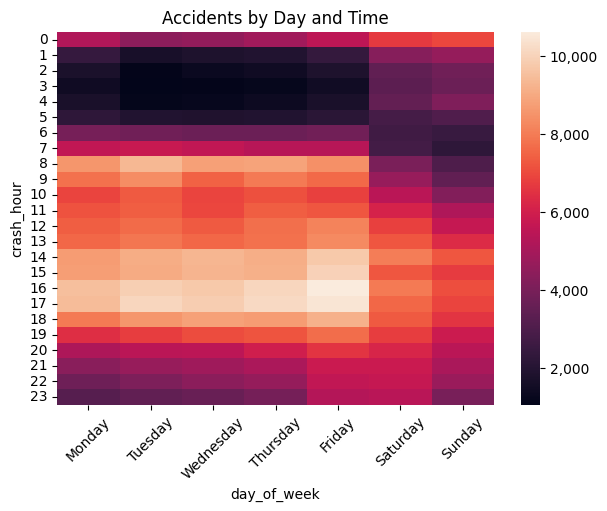

In [16]:
# Creating 'DAY OF WEEK' and 'CRASH HOUR' columns
traffic_df['day_of_week'] = traffic_df['crash_date'].dt.day_name()
traffic_df['crash_hour'] = traffic_df['crash_time'].dt.hour

# Creating dataframe to group accidents by day of week and index them by crash hour
accident_counts_day_time = traffic_df.groupby(['crash_hour','day_of_week']).size().reset_index(name='count')
accident_heatmap_data = accident_counts_day_time.pivot(index= 'crash_hour', columns= 'day_of_week', values='count')

# Reordering 'DAYS OF WEEK'
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.title('Accidents by Day and Time')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()

# Creating barchart
accident_heatmap_data = accident_heatmap_data.reindex(columns = day_order)
ax = sns.heatmap(accident_heatmap_data)

# Format the colorbar values with commas
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

In [17]:

print(f"Total Accidents by {accident_heatmap_data.sum()}")

Peak_Accidents_mask = accident_counts_day_time['count'].max()
Trough_Accidents_mask = accident_counts_day_time['count'].min()

print('The Most Accidents Occured On')
print('--------------------------------')
print(accident_counts_day_time[accident_counts_day_time['count'] == Peak_Accidents_mask]) 
print('   ')
print('The Least Accidents Occured On')
print('--------------------------------')
print(accident_counts_day_time[accident_counts_day_time['count'] == Trough_Accidents_mask])

Total Accidents by day_of_week
Monday       136631
Tuesday      139631
Wednesday    138305
Thursday     142375
Friday       151512
Saturday     131596
Sunday       118269
dtype: int64
The Most Accidents Occured On
--------------------------------
     crash_hour day_of_week  count
112          16      Friday  10609
   
The Least Accidents Occured On
--------------------------------
    crash_hour day_of_week  count
26           3     Tuesday   1047


### Most Frequent Accident Causes
The most common cause of accidents at all hours is "Driver Inattention/Distraction." This is followed by "Following too Closely" and "Failure to Yield Right-of-Way" during most hours of the day. While the majority of accident causes remain consistent throughout all hours, however, "Unsafe Speed" saw an increase in the evening through the early morning. This is likely due to the lower volume of cars on the road during those periods.

<Axes: title={'center': 'Secondary Reason'}, xlabel='Hour of Day', ylabel='count'>

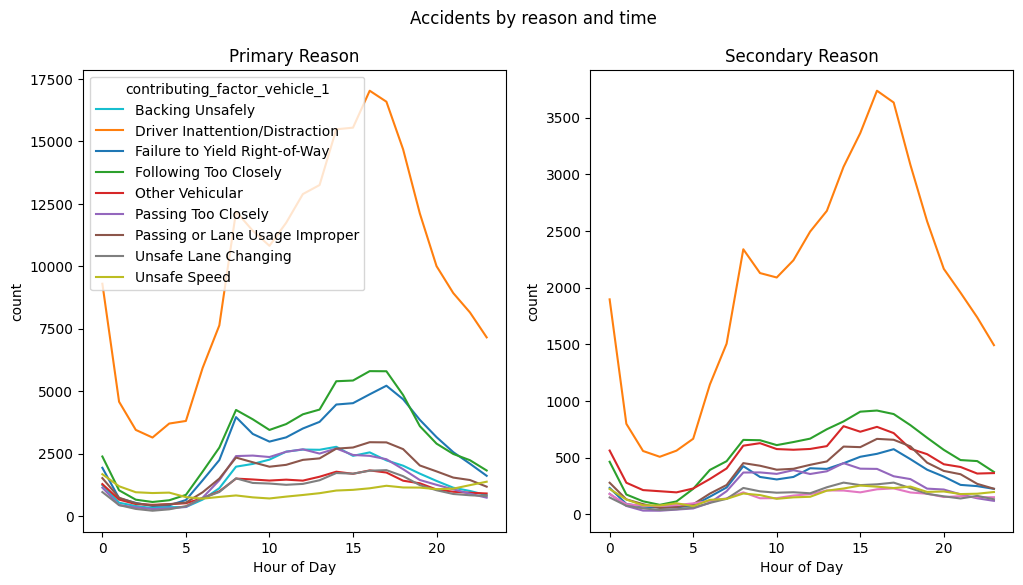

In [18]:
# Creating objects to filter contributing factors
Top_10_factors = traffic_df['contributing_factor_vehicle_1'].value_counts(ascending = False).head(10).index.tolist()
Top_10_factors_2 = traffic_df['contributing_factor_vehicle_2'].value_counts(ascending = False).head(10).index.tolist()

# Counting contributing factors by crash hour and contributing factor
accident_counts_reason_time = traffic_df.groupby(['crash_hour','contributing_factor_vehicle_1']).size().reset_index(name = 'count')
accident_counts_reason_time_2 = traffic_df.groupby(['crash_hour','contributing_factor_vehicle_2']).size().reset_index(name = 'count')

# Applying filters
accident_counts_reason_time_filtered = accident_counts_reason_time[accident_counts_reason_time['contributing_factor_vehicle_1'].isin(Top_10_factors) & (accident_counts_reason_time['contributing_factor_vehicle_1'] != 'Unspecified')]
accident_counts_reason_time_2_filtered = accident_counts_reason_time_2[accident_counts_reason_time_2['contributing_factor_vehicle_2'].isin(Top_10_factors_2) & (accident_counts_reason_time_2['contributing_factor_vehicle_2'] != 'Unspecified')]

# Creating color dictionary and lineplots
fig,ax = plt.subplots(1,2,figsize=(12,6))
plt.suptitle('Accidents by reason and time')
ax[0].set_title('Primary Reason'), ax[1].set_title('Secondary Reason')
ax[0].set_xlabel('Hour of Day'),ax[1].set_xlabel('Hour of Day')

color_dict = {'Driver Inattention/Distraction':'#ff7f0e','Other Vehicular':'#d62728','Failure to Yield Right-of-Way':'#1f77b4','Following Too Closely':'#2ca02c','Passing Too Closely':'#9467bd','Passing or Lane Usage Improper':'#8c564b','Unsafe Lane Changing':'#7f7f7f','Unsafe Speed':'#bcbd22','Passing Too Closely':'#9467bd','Backing Unsafely':'#17becf','Traffic Control Disregarded':'#e377c2'}

sns.lineplot(data = accident_counts_reason_time_filtered,x = 'crash_hour',y = 'count',hue = 'contributing_factor_vehicle_1',ax=ax[0], palette = color_dict)
sns.lineplot(data = accident_counts_reason_time_2_filtered,x = 'crash_hour',y = 'count',hue = 'contributing_factor_vehicle_2',ax=ax[1], palette = color_dict,legend = False)

### Most Accident Prone Vehicles
The top 5 most common vehicles involved in accidents are Sedans and SUVs by far, followed by  Taxis, Bikes, and Pick-up Trucks. The prevalence of Sedans and SUVs/Station wagons are likely responsible for their high numbers. The prescence of bikes in the top 5 vehicles in accidents shows the need for not only improved traffic regulations, but also protection for cyclist.

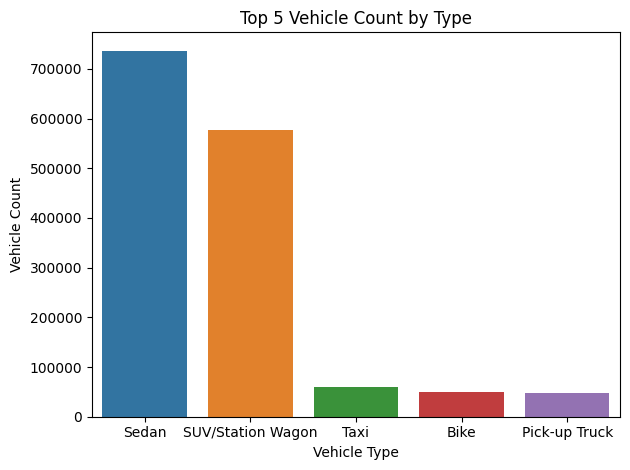

In [19]:
# Making chart easier to read
traffic_df['vehicle_type_code_1']
traffic_df['vehicle_type_code_2']

# Creating objects for vehicle codes
vehicles_codes_1 = traffic_df['vehicle_type_code_1']
vehicles_codes_2 = traffic_df['vehicle_type_code_2']

# Concatenating dataframes and removing null values
combined_vehicle_codes = pd.concat([vehicles_codes_1, vehicles_codes_2])
vehicle_totals = combined_vehicle_codes.value_counts().reset_index()
vehicle_totals.columns = ['vehicle_type','count']
vehicle_totals_clean = vehicle_totals[vehicle_totals['vehicle_type'] != 'nan']

# Making chart easier to read
vehicle_totals_clean = vehicle_totals_clean.replace('Station Wagon/Sport Utility Vehicle', 'SUV/Station Wagon')

# Getting top 5 vehicles overall and creating a barchart 
top_5_vehicles = vehicle_totals_clean.head(5)
sns.barplot(data = top_5_vehicles, x = 'vehicle_type', y = 'count')



    
plt.title("Top 5 Vehicle Count by Type")
plt.xlabel('Vehicle Type')
plt.ylabel('Vehicle Count')
plt.tight_layout()

## Borough Statistics

Brooklyn, followed by Queens, had the most accidents over the period. This was followed by Manhattan, the Bronx, and Staten Island, respectively. Total injuries and fatalities followed the same trend. However, while the injury and fatality rates were similar across boroughs, Brooklyn had the highest injury rate, while Staten Island had the highest fatality rate. Out of all the boroughs, Manhattan had the highest non-motorist injury rate, likely due to the high amount of foot and bike traffic compared to the other boroughs.

In [20]:
# Creating borough stats dataframe, renaming, and adding columns
borough_stats = traffic_df.groupby('borough').agg({
    'collision_id': 'count',  # accidents count
    'number_of_persons_injured': 'sum',
    'number_of_persons_killed': 'sum', 
    'number_of_motorist_injured': 'sum',
    'number_of_motorist_killed': 'sum',
    'number_of_pedestrians_injured':'sum',
    'number_of_pedestrians_killed': 'sum',
    'number_of_cyclist_injured': 'sum',
    'number_of_cyclist_killed': 'sum'
    }).reset_index()

borough_stats.columns = ['borough', 'accidents', 'injuries', 'fatalities','motorist_inj','motorist_fat', 'pedestrian_inj','pedestrian_fat','cyclist_inj', 'cyclist_fat']

borough_stats['non_driver_inj'] = (borough_stats['cyclist_inj'] + borough_stats['pedestrian_inj'])
borough_stats['non_driver_fat'] = (borough_stats['cyclist_fat'] + borough_stats['pedestrian_fat'])

# Calculating rates
pct_rate = ['injury_rate', 'fatality_rate', 'motorist_injury_rate', 'motorist_fat_rate', 'non_driver_inj_rate', 'non_driver_fat_rate']
totals = ['injuries', 'fatalities', 'motorist_inj', 'motorist_fat', 'non_driver_inj', 'non_driver_fat']

for i, col in enumerate(totals):
    if col in borough_stats.columns and i < len(pct_rate):
        borough_stats[pct_rate[i]] = (borough_stats[col] / borough_stats['accidents'] * 100).round(2)

# Formatting outputs
display = borough_stats.copy()
numeric_cols = ['injuries','motorist_inj','non_driver_inj', 'fatalities','motorist_fat','non_driver_fat']  # specify your columns

for col in numeric_cols:
    if col in display.columns:
        display[col] = display[col].apply(lambda x: f'{x:,.0f}' if pd.notna(x) else x)
        
pct_col = ['injury_rate','fatality_rate','motorist_injury_rate','motorist_fat_rate','non_driver_inj_rate','non_driver_fat_rate']

for col in pct_col:
        if col in display.columns:
            display[col] = display[col].apply(lambda x: f'{x:,.2f}%' if pd.notna(x) else x)
            
# Reordering output
col_order = ['borough', 'accidents', 'injuries','injury_rate','fatalities','fatality_rate','motorist_inj','motorist_injury_rate','motorist_fat','motorist_fat_rate','non_driver_inj','non_driver_inj_rate','non_driver_fat','non_driver_fat_rate']

display[col_order]

,borough,accidents,injuries,injury_rate,fatalities,fatality_rate,motorist_inj,motorist_injury_rate,motorist_fat,motorist_fat_rate,non_driver_inj,non_driver_inj_rate,non_driver_fat,non_driver_fat_rate
0,BRONX,150386,"62,667",41.67%,322,0.21%,"46,834",31.14%,158,0.11%,"14,502",9.64%,149,0.10%
1,BROOKLYN,285294,"119,031",41.72%,515,0.18%,"81,357",28.52%,173,0.06%,"34,155",11.97%,323,0.11%
2,MANHATTAN,164880,"52,526",31.86%,277,0.17%,"28,376",17.21%,77,0.05%,"22,740",13.79%,190,0.12%
3,QUEENS,257521,"102,179",39.68%,505,0.20%,"78,693",30.56%,239,0.09%,"21,395",8.31%,254,0.10%
4,STATEN ISLAND,42226,"16,470",39.00%,93,0.22%,"13,489",31.94%,53,0.13%,"2,884",6.83%,39,0.09%


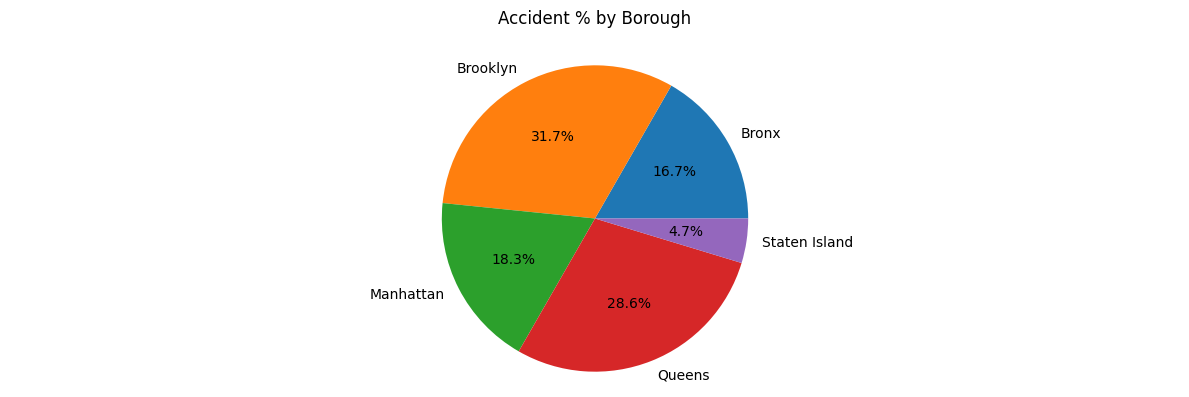

In [21]:
# Creating barchart of % of total accidents
fig, ax = plt.subplots(figsize=(12, 4))
plt.suptitle('Accident % by Borough')
plt.pie(data = borough_stats,x = 'accidents', autopct='%1.1f%%', labels = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.axis('equal')  # Ensuring pie chart is centered
plt.tight_layout()
plt.show()

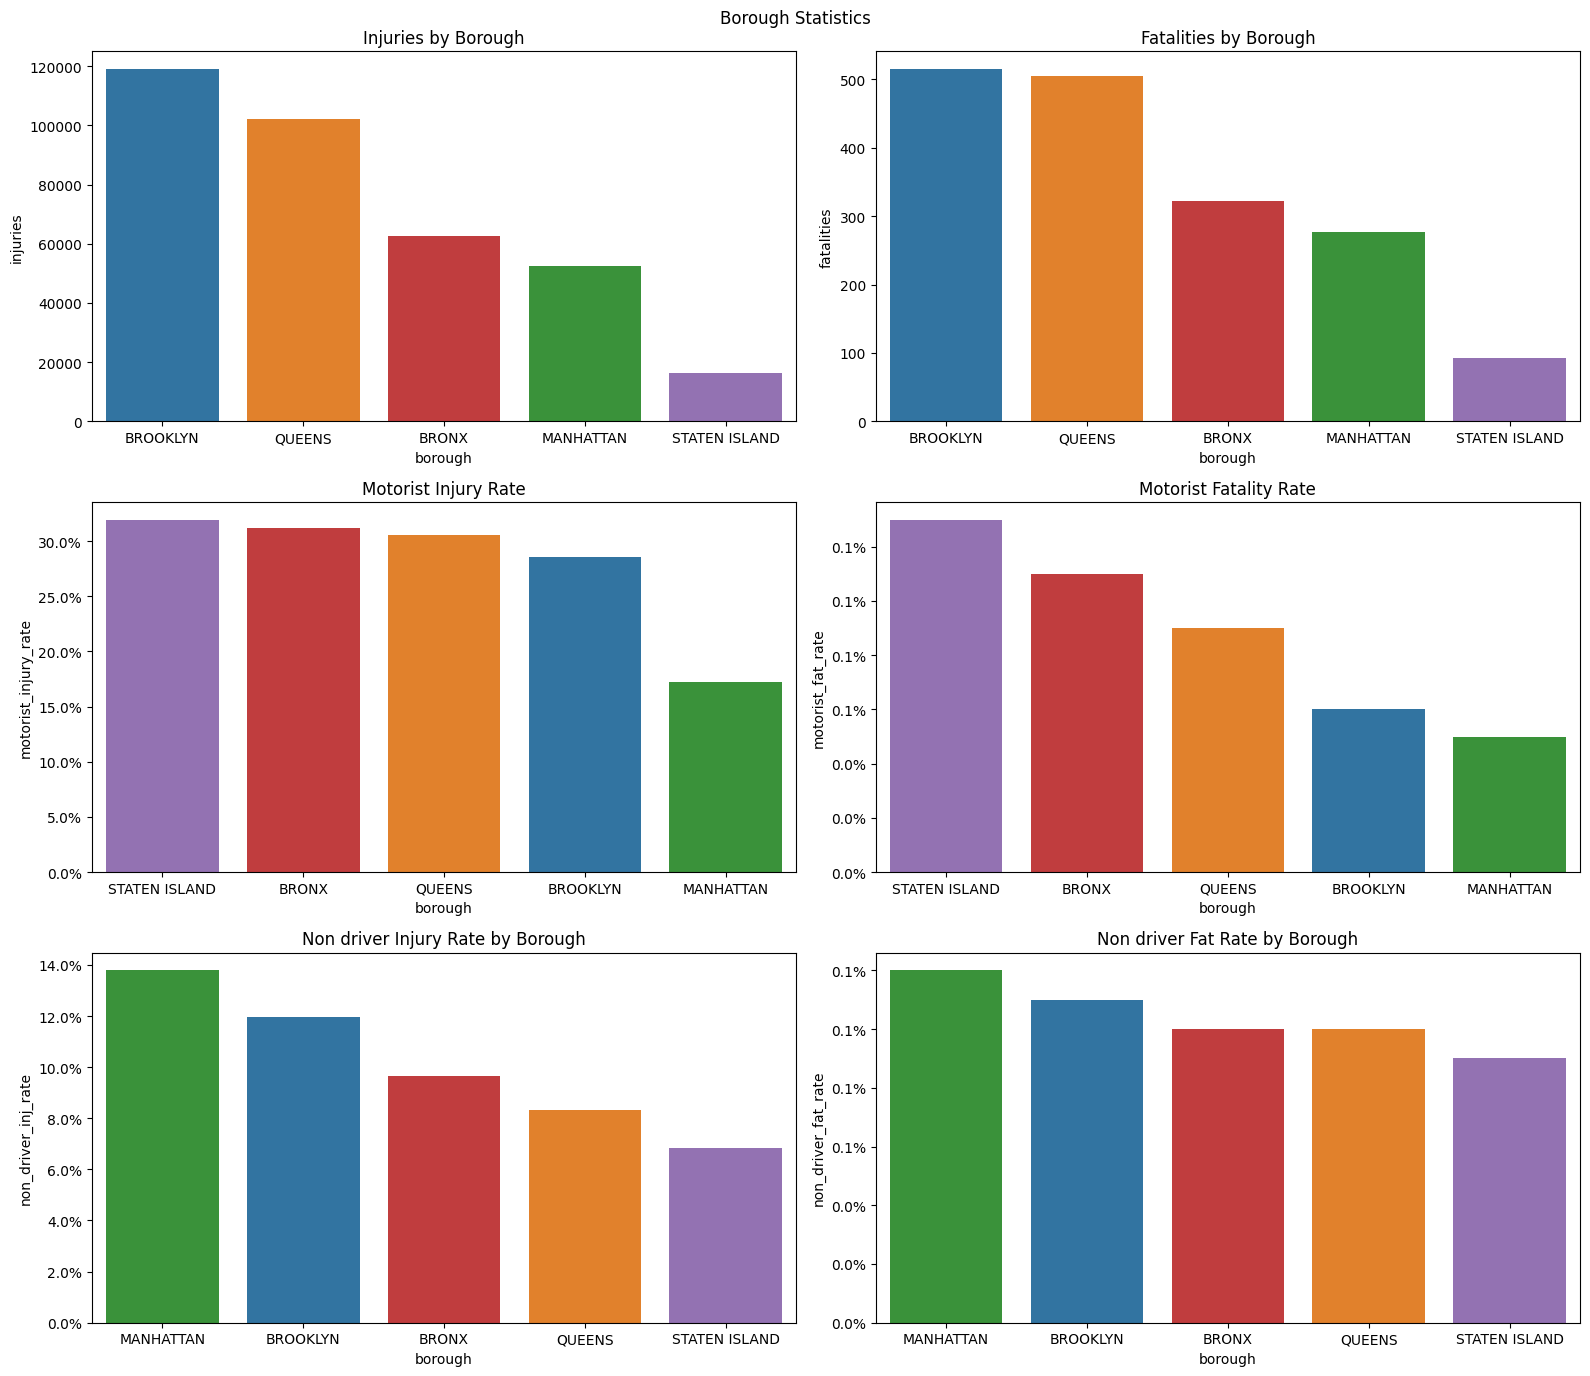

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(16, 14))
plt.suptitle('Borough Statistics')

# Defining plot configurations
plot_configs = [
    ('Injuries by Borough', 'injuries', (0, 0), False),
    ('Fatalities by Borough', 'fatalities', (0, 1), False),
    ('Motorist Injury Rate', 'motorist_injury_rate', (1, 0), True),
    ('Motorist Fatality Rate', 'motorist_fat_rate', (1, 1), True),
    ('Non driver Injury Rate by Borough', 'non_driver_inj_rate', (2, 0), True),
    ('Non driver Fat Rate by Borough', 'non_driver_fat_rate', (2, 1), True)
]

color_dict = {
    'BROOKLYN': '#1f77b4',
    'QUEENS': '#ff7f0e', 
    'MANHATTAN': '#2ca02c',
    'BRONX': '#d62728',
    'STATEN ISLAND': '#9467bd'
}

# Create barplots using a for loop
for title, column, position, is_percentage in plot_configs:
    row, col = position
    
    # Setting title
    ax[row, col].set_title(title)
    
    # Formatting y-axis for percentage plots
    if is_percentage:
        ax[row, col].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    
    # Ordering plot bars
    order = borough_stats.sort_values(column, ascending=False)['borough'].tolist()
    
    # Creating barplots
    sns.barplot(data=borough_stats, x='borough', y=column, ax=ax[row, col], 
                order=order, palette=color_dict)

plt.tight_layout()
plt.show()

# NYC Now

While not included in the scope of the analysis in 2025 YTD accidents and traffic related deaths in NYC have dropped to their lowest levels in recorded history. This shows that initiatives like Vision Zero's Implementations such as 24/7 speed cameras, corridor redesigns, street conversions, and bike lane expansions have helped to make NYC Streets not only safer, but more accessible. Its up to all of us to not only make the streets of NYC safer, but all out streets by being more mindful and attentive before we step behind the wheel.

# References

Datasets
- External [NYC Planning -Borough Boundaries](https://www.nyc.gov/content/planning/pages/resources/datasets/borough-boundaries)
- External [NYC Open Data - Motor Vehicle Collisions](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data)
- External [NYC Open Data - Automated Traffic Volume Counts](https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/7ym2-wayt/about_data)

Articles

- [NYC DOT - Vision Zero: NYC DOT Announces Traffic Deaths Reached Lowest Level in Recorded History](https://www.nyc.gov/html/dot/html/pr2025/vision-zero.shtml) 


- [NYC DOT - Year of Record Achievements, Initiatives to Reimagine the Use of Public Space](https://www.nyc.gov/html/dot/html/pr2023/nyc-dot-2023.shtml) 